In [122]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import matplotlib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.utils import to_categorical

In [124]:
data = pd.read_csv('红酒质量-已清洗.csv')
X = data.drop('quality', axis=1)  
Y = data['quality']

In [126]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [128]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

In [130]:
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, test_size=0.2, random_state=5)

In [132]:
param_grid = {
    'C': [0.1, 1, 10, 100],  # 正则化参数
    'gamma': ['scale', 'auto', 0.1, 1, 10],  # 核函数的系数
    'kernel': ['linear', 'rbf'] 
}

In [154]:
svc = SVC(probability=True)
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

In [156]:
grid_search.fit(X_train, Y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best cross-validation score: 0.6487336442544371


In [158]:
best_svc = grid_search.best_estimator_

In [160]:
X_train_prediction = best_svc.predict(X_train)
train_data_accuracy = accuracy_score(X_train_prediction,Y_train)
f1_train =f1_score(X_train_prediction,Y_train,average='weighted')
print(train_data_accuracy)
print(f1_train)

0.9421221864951769
0.9445968293415733


In [162]:
X_test_prediction = best_svc.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction,Y_test)
f1_test =f1_score(X_test_prediction,Y_test,average='weighted')
print(test_data_accuracy)
print(f1_test)

0.6334405144694534
0.6613545017996455


In [164]:
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示为方块的问题plt.figure(figsize=(10, 7))

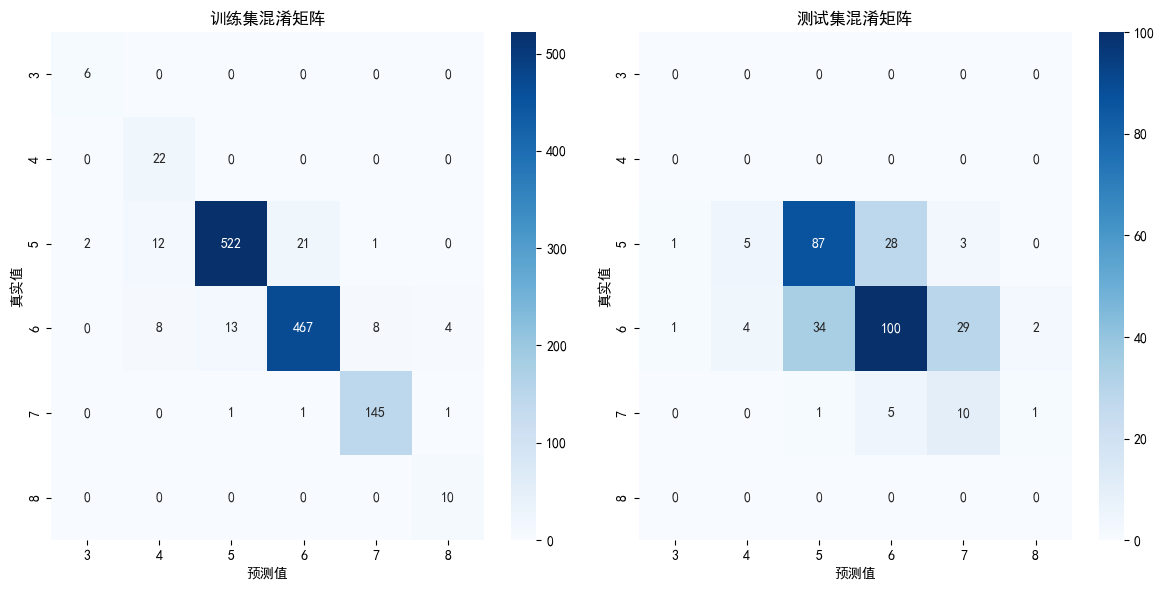

In [166]:
conf_matrix = confusion_matrix(X_train_prediction,Y_train)
conf_matrix_test = confusion_matrix(X_test_prediction,Y_test)

# 设置图形大小
fig_size = (12, 6)  # 12 英寸宽, 6 英寸高
fig, ax = plt.subplots(1, 2, figsize=fig_size)

# 绘制训练集的混淆矩阵
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[3, 4, 5, 6, 7, 8],  # 根据你的分类标签修改
            yticklabels=[3, 4, 5, 6, 7, 8], ax=ax[0])  # 使用ax[0]指定在哪个子图上绘制
ax[0].set_ylabel('真实值')
ax[0].set_xlabel('预测值')
ax[0].set_title('训练集混淆矩阵')

# 绘制测试集的混淆矩阵
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[3, 4, 5, 6, 7, 8],  # 根据你的分类标签修改
            yticklabels=[3, 4, 5, 6, 7, 8], ax=ax[1])  # 使用ax[1]指定在哪个子图上绘制
ax[1].set_ylabel('真实值')
ax[1].set_xlabel('预测值')
ax[1].set_title('测试集混淆矩阵')

# 自动调整布局
plt.tight_layout()
plt.savefig("svc-正则化.png", dpi=300, bbox_inches='tight') 
# 显示图形
plt.show()

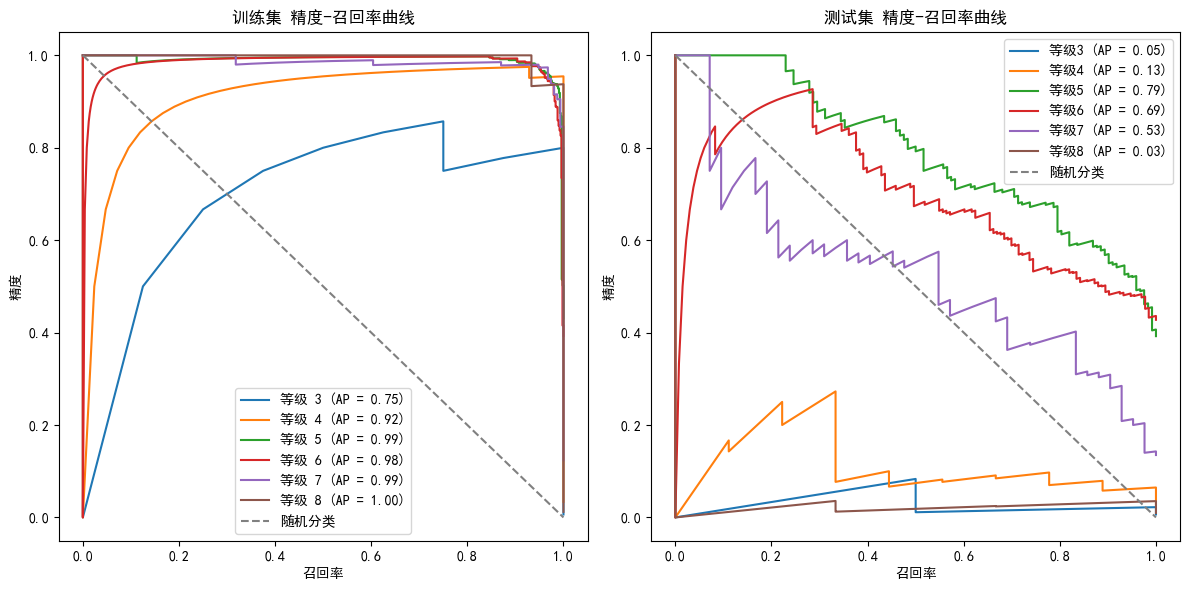

In [172]:
Y_train_probs = best_svc.predict_proba(X_train)
unique_classes_train = np.unique(Y_train)

# 获取测试集的预测概率
Y_test_probs = best_svc.predict_proba(X_test)
unique_classes_test = np.unique(Y_test)

# 设置图形大小和子图的排列 (1 行 2 列)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# 绘制训练集的精度-召回率曲线
for i in unique_classes_train:
    precision, recall, _ = precision_recall_curve(Y_train == i, Y_train_probs[:, i-3])
    ax[0].plot(recall, precision, label=f'等级 {i} (AP = {average_precision_score(Y_train == i, Y_train_probs[:, i-3]):.2f})')

# 绘制测试集的精度-召回率曲线
for i in unique_classes_test:
    precision, recall, _ = precision_recall_curve(Y_test == i, Y_test_probs[:, i-3])
    ax[1].plot(recall, precision, label=f'等级{i} (AP = {average_precision_score(Y_test == i, Y_test_probs[:, i-3]):.2f})')

# 在两个子图中分别绘制随机分类器的对角线
ax[0].plot([0, 1], [1, 0], linestyle='--', color='gray', label='随机分类')
ax[1].plot([0, 1], [1, 0], linestyle='--', color='gray', label='随机分类')

# 设置标题、标签和图例
ax[0].set_title('训练集 精度-召回率曲线')
ax[0].set_xlabel('召回率')
ax[0].set_ylabel('精度')
ax[0].legend(loc='best')

ax[1].set_title('测试集 精度-召回率曲线')
ax[1].set_xlabel('召回率')
ax[1].set_ylabel('精度')
ax[1].legend(loc='best')
plt.savefig("svr-正则化-默认.png", dpi=300, bbox_inches='tight') 
# 自动调整布局
plt.tight_layout()

# 显示图形
plt.show()

In [175]:
df = pd.read_csv('红酒质量-已清洗.csv')
X = df.drop('quality', axis=1)
Y = df['quality']

In [177]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [179]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

In [181]:
Y = to_categorical(Y - 3, num_classes=6) 

In [183]:
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, test_size=0.2, random_state=5)

In [185]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # 输入层
model.add(Dropout(0.2))  # Dropout层，丢弃20%的神经元
model.add(Dense(64, activation='relu'))  # 隐藏层
model.add(Dropout(0.2))  # Dropout层，丢弃20%的神经元
model.add(Dense(32, activation='relu'))  # 隐藏层
model.add(Dropout(0.2))  # Dropout层，丢弃20%的神经元
model.add(Dense(6, activation='softmax'))  # 输出层，7个类别，使用softmax激活

In [187]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [190]:
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/50
39/39 [==============================] - 0s 2ms/step - loss: 0.7700 - accuracy: 0.6785 - val_loss: 1.0134 - val_accuracy: 0.5916
Epoch 2/50
39/39 [==============================] - 0s 2ms/step - loss: 0.7522 - accuracy: 0.6833 - val_loss: 1.0069 - val_accuracy: 0.5981
Epoch 3/50
39/39 [==============================] - 0s 2ms/step - loss: 0.7361 - accuracy: 0.6986 - val_loss: 1.0277 - val_accuracy: 0.5884
Epoch 4/50
39/39 [==============================] - 0s 2ms/step - loss: 0.7375 - accuracy: 0.6929 - val_loss: 1.0387 - val_accuracy: 0.5820
Epoch 5/50
39/39 [==============================] - 0s 2ms/step - loss: 0.7401 - accuracy: 0.6809 - val_loss: 1.0203 - val_accuracy: 0.5820
Epoch 6/50
39/39 [==============================] - 0s 2ms/step - loss: 0.7316 - accuracy: 0.6994 - val_loss: 1.0376 - val_accuracy: 0.5981
Epoch 7/50
39/39 [==============================] - 0s 2ms/step - loss: 0.7169 - accuracy: 0.7042 - val_loss: 1.0241 - val_accuracy: 0.6045
Epoch 8/50
39/39 [==

In [191]:
Y_train_class = np.argmax(Y_train, axis=1)
Y_train_pred = model.predict(X_train)
Y_train_pred_max = np.argmax(Y_train_pred, axis=1)
accuracy = accuracy_score(Y_train_class, Y_train_pred_max)
print(f"Accuracy: {accuracy:.4f}")
f1_train = f1_score(Y_train_class, Y_train_pred_max, average='weighted')
print(f"F1 Score (weighted): {f1_train:.4f}")

39/39 [==============================] - 0s 684us/step
Accuracy: 0.8055
F1 Score (weighted): 0.7956


In [194]:
Y_test_class = np.argmax(Y_test, axis=1)
Y_test_pred = model.predict(X_test)
Y_test_pred_max = np.argmax(Y_test_pred, axis=1)
accuracy = accuracy_score(Y_test_class, Y_test_pred_max)
print(f"Accuracy: {accuracy:.4f}")
f1_test = f1_score(Y_test_class, Y_test_pred_max, average='weighted')
print(f"F1 Score (weighted): {f1_test:.4f}")

10/10 [==============================] - 0s 778us/step
Accuracy: 0.6238
F1 Score (weighted): 0.6097


10/10 [==============================] - 0s 778us/step


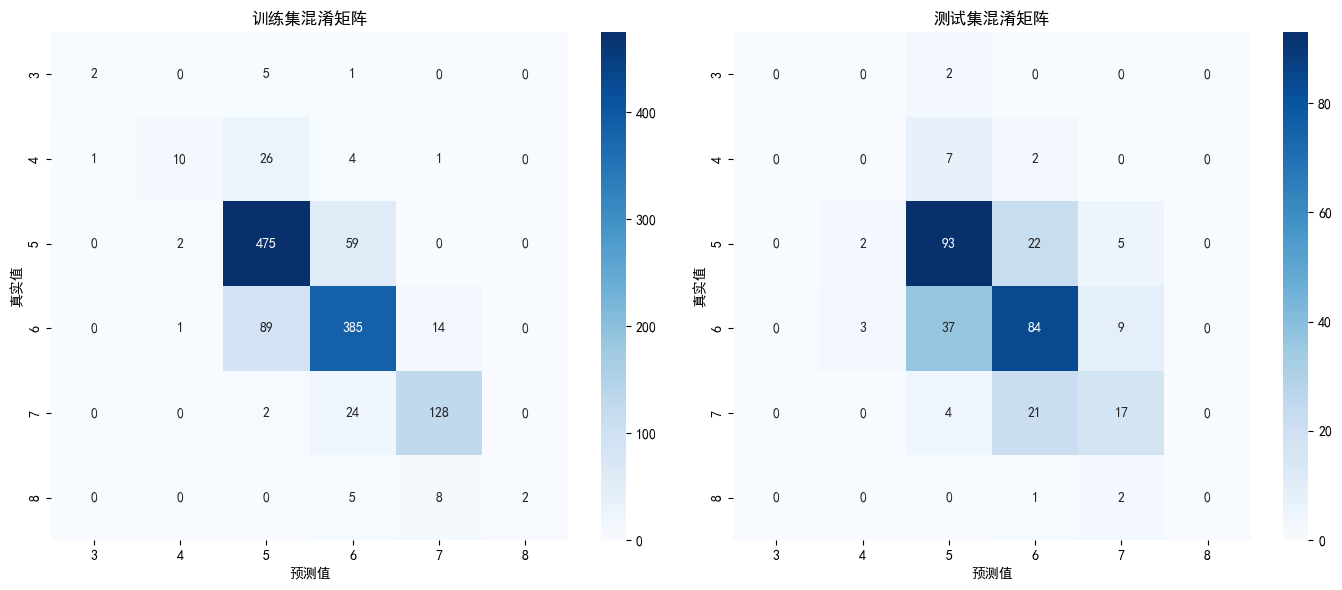

In [214]:
Y_train_pred = np.argmax(model.predict(X_train), axis=1)
Y_test_pred = np.argmax(model.predict(X_test), axis=1)

# 真实标签
Y_train_true = np.argmax(Y_train, axis=1)
Y_test_true = np.argmax(Y_test, axis=1)

# 计算训练集和测试集的混淆矩阵
conf_matrix_train = confusion_matrix(Y_train_true, Y_train_pred)
conf_matrix_test = confusion_matrix(Y_test_true, Y_test_pred)

# 绘制混淆矩阵
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# 绘制训练集混淆矩阵
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[3, 4, 5, 6, 7, 8],  # 根据你的分类标签修改
            yticklabels=[3, 4, 5, 6, 7, 8], ax=ax[0])  # 使用ax[0]指定在哪个子图上绘制
ax[0].set_ylabel('真实值')
ax[0].set_xlabel('预测值')
ax[0].set_title('训练集混淆矩阵')

# 绘制测试集的混淆矩阵
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[3, 4, 5, 6, 7, 8],  # 根据你的分类标签修改
            yticklabels=[3, 4, 5, 6, 7, 8], ax=ax[1])  # 使用ax[1]指定在哪个子图上绘制
ax[1].set_ylabel('真实值')
ax[1].set_xlabel('预测值')
ax[1].set_title('测试集混淆矩阵')

# 自动调整布局
plt.tight_layout()
plt.savefig("NN-正则化.png", dpi=300, bbox_inches='tight') 
# 显示图形
plt.show()

10/10 [==============================] - 0s 778us/step


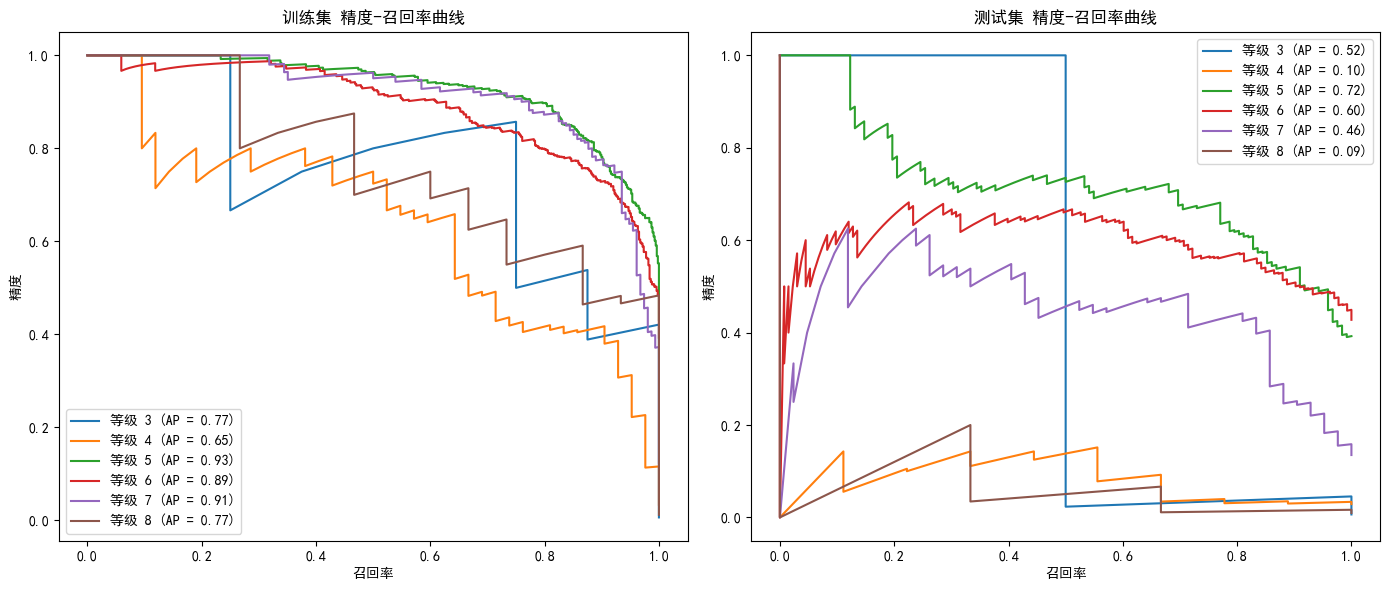

In [216]:
Y_train_true = np.argmax(Y_train, axis=1)
Y_test_true = np.argmax(Y_test, axis=1)

# 获取训练集和测试集的类别预测概率
Y_train_probs = model.predict(X_train)
Y_test_probs = model.predict(X_test)

# 创建子图
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# 绘制训练集的精度-召回率曲线
for i in range(6):  # 6个类别（0, 1, 2, 3, 4, 5）
    precision, recall, _ = precision_recall_curve(Y_train_true == i, Y_train_probs[:, i])
    average_precision = average_precision_score(Y_train_true == i, Y_train_probs[:, i])
    ax[0].plot(recall, precision, label=f'等级 {i+3} (AP = {average_precision:.2f})')

ax[0].set_title('训练集 精度-召回率曲线')
ax[0].set_xlabel('召回率')
ax[0].set_ylabel('精度')
ax[0].legend(loc='best')

# 绘制测试集的精度-召回率曲线
for i in range(6):  # 6个类别（0, 1, 2, 3, 4, 5）
    precision, recall, _ = precision_recall_curve(Y_test_true == i, Y_test_probs[:, i])
    average_precision = average_precision_score(Y_test_true == i, Y_test_probs[:, i])
    ax[1].plot(recall, precision, label=f'等级 {i+3} (AP = {average_precision:.2f})')

ax[1].set_title('测试集 精度-召回率曲线')
ax[1].set_xlabel('召回率')
ax[1].set_ylabel('精度')
ax[1].legend(loc='best')

plt.tight_layout()
plt.savefig('NN-正则化-精度召回率曲线.png', dpi=300)
plt.show()